In [1]:
#imports

# import random
import pandas as pd
import numpy as np
import pickle
import pygmo as pg
import matplotlib.pyplot as plt
import seaborn as sns


# # Own Model import
from lib.fl_model_v10 import *
import lib
# # import lib.fl_model_v5 as flm

# # for natural sorting
import re

# #for nondominated sorting
import lib.pareto as pareto
# # from lib.list_imports import find_loaded_modules

# # for parallel plotting
# from lib.parallel_plotting import plot_optimal

# # For checking ema running time
# import time

# import importlib

# import geopy
# from geopy.distance import great_circle 

In [2]:
case = "Nepal"
output_folder = "Simulation-results"

## Load Data for reevaluation of policies under perfect information

In [3]:
Fix_Unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case), index_col=0)

DPs = pd.read_csv("{}/Prepared Input Data/DPs.csv".format(case))
# DPs.columns

FLs = pd.read_csv("{}/Prepared Input Data/FLs.csv".format(case))
# FLs.columns

SPs = pd.read_csv("{}/Prepared Input Data/SPs.csv".format(case))
# SPs.columns

# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}


In [4]:
Fix_Unc

,lower,best_estimate,upper
var,,,
unit_transport_cost,7,10,15
FL_range,1,3,5
demand_per_affected,5,10,15


In [5]:
epicentre_name = "RealLocation"
print("Pick right Epicentre, and/or load disruption data.\n",
      "Epicentre chosen: {}".format(epicentre_name))

Pick right Epicentre, and/or load disruption data.
 Epicentre chosen: RealLocation


In [6]:
disruptionsFLs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionFL{}.txt'.format(epicentre_name))
disruptionsDPs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionDP{}.txt'.format(epicentre_name))

In [7]:
# Base real values on Nepal earthquake
# DSR is abbreviation for Disruption

DSRDP = {"DSRDP{}".format(i): disruptionsDPs[i] for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): disruptionsFLs[i] for i in range(len(FLX))}

## Create MOO results for perfect information

In [8]:
from itertools import product
# Create All possible policies
start_situation = {key: 0 for key in FLs.Name}

# Create all possible permutations for
permutations = [i for i in product([0, 1], repeat=len(FLs)) if sum(i) == 4]
print(
    "There are {} possible solutions where there are four different facility locations operational".
    format(len(permutations)))

# Convert possible permutations to policies
All_optional_pols = []
for p in permutations:
    tmp = {"FLO{}".format(i):val for i,val in enumerate(p)}
    All_optional_pols.append(tmp)

There are 4845 possible solutions where there are four different facility locations operational


In [9]:
# Evaluate all optional policies with best estimate values
Perfect_Info_Results = []
for policy in All_optional_pols:
    Perfect_Info_Results.append(
        FL_model(
#             unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
#             FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))

### Find Pareto Front for Perfect Infomration

In [10]:
#Filter out those where the constraint is not satisfied

# outcome indicators, as internally used by the model
oois = [
    'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_travel_time'
]
# Put outcomes in DF

DF_Perfect_Info_Results = pd.DataFrame(
    np.asarray(Perfect_Info_Results)[:, :5], columns=oois + ["constraint"])
# DF_Perfect_Info_Results.tail()

DF_Perfect_Info_Results_filtered = DF_Perfect_Info_Results[
    DF_Perfect_Info_Results.constraint]
print("There are {} solutions remaining after filtering for the constraint".
      format(DF_Perfect_Info_Results_filtered.shape[0]))
DF_Perfect_Info_Results_filtered.head()

There are 1297 solutions remaining after filtering for the constraint


,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_travel_time,constraint
3,177410,24,7995.39,60234,True
7,92385.7,26,8982.6,59777.4,True
10,175031,24,7995.39,59777.4,True
12,178597,24,7995.39,59777.4,True
14,158112,25,8068.33,79058,True


In [11]:
# Get Pareto Front by NonDominated Sorting
PF_MOO = np.array(pareto.eps_sort(
    [list(DF_Perfect_Info_Results_filtered.itertuples(index=True))], [1, 2, 3, 4],
    [1e-9, 1e-9, 1e-9, 1e-9]))

DF_PF_MOO = pd.DataFrame(PF_MOO).set_index(0)
print("There are {} solutions in the pareto front for Perfect Information".
      format(DF_PF_MOO.shape[0]))

There are 55 solutions in the pareto front for Perfect Information


## Load mpmordm results

In [13]:
with open('{}/{}/python_objects.pickle'.format(case, output_folder),
          'rb') as handle:
    global_label_tree, EMA_model_dict, global_dfs_var_unc_data, global_fixed_unc, global_policy_tree = pickle.load(
        handle)

## Reevaluate MPMORDM results for perfect information

In [14]:
p4_labels = global_label_tree['p4']

In [15]:
p4_pols = [global_policy_tree[label] for label in p4_labels]

In [16]:
print("P4 after Multi-Period Robust Optimisation contains {} number of policies".format(len(p4_pols)))

P4 after Multi-Period Robust Optimisation contains 1152 number of policies


In [17]:
# Filter to find only unique policies

In [18]:
p4_FLs = np.array([[int(key[3:]) for key, value in pol.items() if value == 1]
                   for pol in p4_pols])
p4_FLs = np.unique(p4_FLs, axis=0)
print("Of all {} policies, {} are unique, the rest are duplicates".format(
    len(p4_pols), p4_FLs.shape[0]))

Of all 1152 policies, 165 are unique, the rest are duplicates


In [19]:
p4_pols_unique = [{
    "FLO{}".format(i): 1 if i in p4_FLs[j] else 0
    for i in range(len(p4_pols[0].keys()))
} for j in range(len(p4_FLs))]

In [21]:
# Evaluate all unique policies with best estimate values
MPMORDMpols_for_real_values_results = []
# for policy in p4_pols_unique:
for policy in p4_pols:    
    MPMORDMpols_for_real_values_results.append(
        FL_model(
#             unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
#             FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))

### Pareto Front MPMORDM: Dynamic Uncertainty 

In [22]:
#Filter out those where the constraint is not satisfied

# outcome indicators, as internally used by the model
oois = [
    'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_travel_time'
]
# Put outcomes in DF

DF_MPMORDMpols_for_real_values_results = pd.DataFrame(
    np.asarray(MPMORDMpols_for_real_values_results)[:, :5], columns=oois + ["constraint"])


DF_MPMORDMpols_for_real_values_results_filtered = DF_MPMORDMpols_for_real_values_results[
    DF_MPMORDMpols_for_real_values_results.constraint]
print("There are {} solutions remaining after filtering for the constraint".
      format(DF_MPMORDMpols_for_real_values_results_filtered.shape[0]))
DF_MPMORDMpols_for_real_values_results_filtered.head()

There are 1152 solutions remaining after filtering for the constraint


,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_travel_time,constraint
0,1.07736e+06,13,2992.29,53409.1,True
1,1.23649e+06,10,1619.21,53409.1,True
2,406905,17,6064.99,53409.1,True
3,334802,19,7129.9,59777.4,True
4,371255,18,6724.11,60500,True


This is expected, because they already had to satisfy for the constraint during the mpmordm cycle

In [23]:
# Get Pareto Front by NonDominated Sorting
PF_MPMORDM = np.array(pareto.eps_sort(
    [list(DF_MPMORDMpols_for_real_values_results_filtered.itertuples(index=True))], [1, 2, 3, 4],
    [1e-9, 1e-9, 1e-9, 1e-9]))

DF_PF_MPMORDM = pd.DataFrame(PF_MPMORDM).set_index(0)
print("There are {} solutions in the pareto front for the MPMORDM".
      format(DF_PF_MPMORDM.shape[0]))

There are 54 solutions in the pareto front for the MPMORDM


In [24]:
kwargs = {"maximize_all":True}
# Get Inverse Pareto Front by NonDominated Sorting
Inverse_PF_MPMORDM = np.array(pareto.eps_sort(
    [list(DF_MPMORDMpols_for_real_values_results_filtered.itertuples(index=True))], [1, 2, 3, 4],
    [1e-9, 1e-9, 1e-9, 1e-9],**kwargs))

DF_Inverse_PF_MPMORDM = pd.DataFrame(Inverse_PF_MPMORDM).set_index(0)
print("There are {} solutions in the inverse pareto front for the MPMORDM".
      format(DF_Inverse_PF_MPMORDM.shape[0]))

There are 44 solutions in the inverse pareto front for the MPMORDM


## Compare Pareto Fronts 

In [25]:
DF_PF_MPMORDM.shape

(54, 5)

In [26]:
DF_PF_MOO.shape

(55, 5)

In [27]:
DF_Inverse_PF_MPMORDM.shape

(44, 5)

In [28]:
pg

<module 'pygmo' from 'C:\\Users\\timro\\Anaconda3\\lib\\site-packages\\pygmo\\__init__.py'>

### Normalise all three dfs

In [29]:
def normalise_df (df):
    df = df.iloc[:,:4]
    normalised_df=(df-df.min())/(df.max()-df.min())
    print("normalised with: min:\n{} and max:\n{}\n\n".format(df.min(),df.max()))
    return normalised_df

In [30]:
def normalise_df_relative (df, minimum, maximum):
    df = df.iloc[:,:4]
    normalised_df=(df-minimum)/(maximum-minimum)
    print("normalised with: min:\n{} and max:\n{}\n\n".format(minimum,maximum))
    return normalised_df

In [31]:
def normalise_multiple_dfs(df_list):
    tmp = pd.DataFrame()
    for df in df_list:
        tmp = tmp.append(df)
    MIN,MAX = tmp.min()[:4], tmp.max()[:4]
    
    normalised_dfs = []
    for df in df_list:
        normalised_dfs.append(normalise_df_relative(df,MIN,MAX))
    return normalised_dfs


In [32]:
normalised_df_list = normalise_multiple_dfs([DF_PF_MOO,DF_PF_MPMORDM,DF_Inverse_PF_MPMORDM])

normalised with: min:
1    76783.263124
2        8.000000
3      554.300229
4    27851.337183
dtype: float64 and max:
1    2.030775e+06
2    2.700000e+01
3    1.661122e+04
4    8.448795e+04
dtype: float64


normalised with: min:
1    76783.263124
2        8.000000
3      554.300229
4    27851.337183
dtype: float64 and max:
1    2.030775e+06
2    2.700000e+01
3    1.661122e+04
4    8.448795e+04
dtype: float64


normalised with: min:
1    76783.263124
2        8.000000
3      554.300229
4    27851.337183
dtype: float64 and max:
1    2.030775e+06
2    2.700000e+01
3    1.661122e+04
4    8.448795e+04
dtype: float64




In [33]:
DF_PF_MOO_norm, DF_PF_MPMORDM_norm, DF_Inverse_PF_MPMORDM_norm = normalised_df_list

In [34]:
DF_PF_MOO_norm.shape

(55, 4)

In [35]:
DF_PF_MPMORDM_norm.shape

(54, 4)

In [36]:
DF_Inverse_PF_MPMORDM_norm.shape

(44, 4)

### Calculate Hypervolume Difference between Ground Truth and MPMORDM

In [37]:
ref_point = [1,1,1,1]

In [38]:
hv_MOO = pg.hypervolume(DF_PF_MOO_norm.values)
# hv_MOO = pg.hypervolume(DF_PF_MOO_norm.iloc[:,:4].astype(float).values)

In [39]:
hv_MOO.compute(ref_point)

0.5205502602682269

In [40]:
hv_MPMORDM = pg.hypervolume(DF_PF_MPMORDM_norm.values)
# hv_MPMORDM = pg.hypervolume(DF_PF_MPMORDM_norm.iloc[:,:4].astype(float).values)

In [41]:
hv_MPMORDM.compute(ref_point)

0.5205404133203992

In [42]:
diff = hv_MOO.compute(ref_point) - hv_MPMORDM.compute(ref_point)

In [43]:
diff

9.846947827685248e-06

### Compare worst pareto front

In [44]:
hv_MPMORDM_inverse = pg.hypervolume(DF_Inverse_PF_MPMORDM_norm.values)

In [45]:
hv_MPMORDM_inverse.compute(ref_point)

0.2560122910977658

In [46]:
hv_MOO.compute(ref_point) - hv_MPMORDM_inverse.compute(ref_point)

0.26453796917046113

## Coverage and Density of MPMORDM solutions in Perfect Info Pareto Front

In [49]:
# PF pols
PFMOOPols = np.array(All_optional_pols)[list(DF_PF_MOO.index.astype(int))]
PFMOOPols.shape
# PF fls
PFMOO_FLS = np.array([[int(key[3:]) for key, value in pol.items() if value == 1]
                   for pol in PFMOOPols])
PFMOO_FLS.shape

(55, 4)

In [50]:
np.unique(PFMOO_FLS, axis=0).shape

(55, 4)

In [51]:
#MPMORDM pols
#total
print("all p4 pols:",len(p4_pols))
#FLS
p4_FLs = np.array([[int(key[3:]) for key, value in pol.items() if value == 1]
                   for pol in p4_pols])
p4_FLs.shape
#unique
np.unique(p4_FLs, axis=0).shape

all p4 pols: 1152


(165, 4)

In [52]:
#MPMORDM PF pols
PFMPMORDMPols = np.array(p4_pols)[list(DF_PF_MPMORDM.index.astype(int))]

#FLS
PFMPMORDM_FLS = np.array([[int(key[3:]) for key, value in pol.items() if value == 1]
                   for pol in PFMPMORDMPols])

PFMPMORDM_FLS.shape

(54, 4)

In [53]:
np.unique(PFMPMORDM_FLS, axis=0).shape

(54, 4)

In [54]:
#MPMORDM invPF pols
InvPFMPMORDMPols = np.array(p4_pols)[list(DF_Inverse_PF_MPMORDM.index.astype(int))]

#FLS
InvPFMPMORDM_FLS = np.array([[int(key[3:]) for key, value in pol.items() if value == 1]
                   for pol in InvPFMPMORDMPols])
InvPFMPMORDM_FLS.shape

(44, 4)

In [55]:
np.unique(InvPFMPMORDM_FLS, axis=0).shape

(44, 4)

### Coverage of PF
How many are in the actual PF?

In [56]:
# MPMORDM PF in MOO
covered = sum([fls.tolist() in PFMOO_FLS.tolist() for fls in PFMPMORDM_FLS])
print(covered,"in",PFMOO_FLS.shape[0],":")
print(covered / PFMOO_FLS.shape[0] * 100,"%")

54 in 55 :
98.18181818181819 %


In [57]:
sum([fls.tolist() in PFMPMORDM_FLS.tolist() for fls in PFMOO_FLS])

54

In [58]:
# MPMORDM InversePF in MOO
covered = sum([fls.tolist() in PFMOO_FLS.tolist() for fls in InvPFMPMORDM_FLS])
print(covered,"in",PFMOO_FLS.shape[0],":")
print(covered / PFMOO_FLS.shape[0] * 100,"%")

15 in 55 :
27.27272727272727 %


### Density
How many of the PF are in all solutions?

In [59]:
p4_FLs.shape

(1152, 4)

In [60]:
# Density Inverse PF
occurences = sum([fls.tolist() in InvPFMPMORDM_FLS.tolist() for fls in p4_FLs])
print(occurences,"of the",p4_FLs.shape[0],":")
print(occurences/p4_FLs.shape[0]*100,"%")

233 of the 1152 :
20.225694444444446 %


In [61]:
# Density PF
occurences = sum([fls.tolist() in PFMPMORDM_FLS.tolist() for fls in p4_FLs])
occurences
print(occurences,"of the",p4_FLs.shape[0],":")
print(occurences/p4_FLs.shape[0]*100,"%")


614 of the 1152 :
53.298611111111114 %


In [62]:
#Intermediate Solutions
occurences = sum([fls.tolist() not in PFMPMORDM_FLS.tolist() + InvPFMPMORDM_FLS.tolist() for fls in p4_FLs])
occurences
print(occurences,"of the",p4_FLs.shape[0],":")
print(occurences/p4_FLs.shape[0]*100,"%")


442 of the 1152 :
38.36805555555556 %


In [63]:
#Overlap PF and IPF Solutions
occurences = sum([fls.tolist() in PFMPMORDM_FLS.tolist() and fls.tolist() in InvPFMPMORDM_FLS.tolist() for fls in p4_FLs])
occurences
print(occurences,"of the",p4_FLs.shape[0],":")
print(occurences/p4_FLs.shape[0]*100,"%")


137 of the 1152 :
11.89236111111111 %


In [64]:
# Number of overlapping fls
a = [fls.tolist() in PFMPMORDM_FLS.tolist() and fls.tolist() in InvPFMPMORDM_FLS.tolist() for fls in p4_FLs]

np.unique(p4_FLs[a],axis=0).shape

(15, 4)

## Compare Distributions

In [65]:
# Results for Perfect Information
DF_PF_MOO = DF_PF_MOO.iloc[:,:4]
DF_PF_MOO.columns = oois
DF_PF_MOO.shape


(55, 4)

In [66]:
# Results for MPMORDM
DF_P4_MPMORDM_results = DF_MPMORDMpols_for_real_values_results_filtered.iloc[:,:4]
DF_P4_MPMORDM_results.columns = oois
DF_P4_MPMORDM_results.shape

(1152, 4)

In [67]:
DF_PF_MOO.columns

Index(['total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
       'max_travel_time'],
      dtype='object')

In [68]:
OOIs = ['Total Costs', 'Nr. Uncovered Demand Points', 'Total Uncovered Demand', 'Max. Travel Time']

In [69]:
DF_PF_MOO.shape

(55, 4)

In [70]:
DF_P4_MPMORDM_results.shape

(1152, 4)

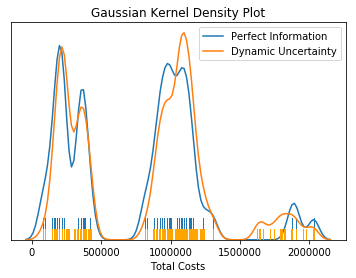

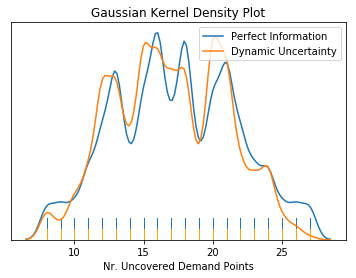

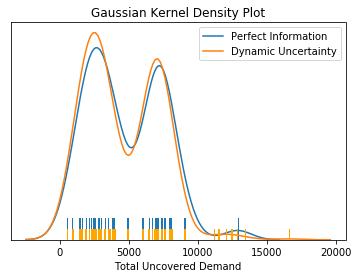

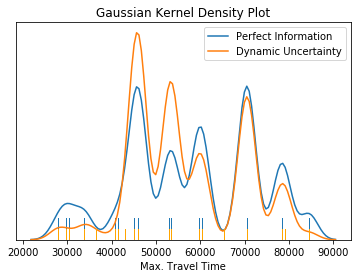

In [82]:
bws = [40000,0.5,1000,2000]
for obj, ooi, bw in zip(DF_PF_MOO.columns, OOIs, bws):
    #     f =
    sns.kdeplot(
        DF_PF_MOO[obj],
        bw=bw,
        label="Perfect Information",
    )
    sns.rugplot(DF_PF_MOO[obj], height=0.1)

    sns.kdeplot(
        DF_P4_MPMORDM_results[obj],
        bw=bw,
        label='Dynamic Uncertainty')
    sns.rugplot(DF_P4_MPMORDM_results[obj], height=0.05, color='orange')

    #     plt.title(ooi)
    plt.xlabel(ooi)

    plt.tick_params(
        axis='y',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        left=False,  # ticks along the bottom edge are off
        right=False,  # ticks along the top edge are off
        labelleft=False)  # labels along the bottom edge are off

    plt.title("Gaussian Kernel Density Plot")
    plt.savefig("{}/Analysis/KDE{}".format(case,obj),dpi=600)
    plt.show()
#     break